In [54]:
import datetime
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pathlib import Path

In [2]:
!python -m pip install --upgrade pip
!pip install supervision==0.3.0
!pip install transformers
!pip install pytorch-lightning
!pip install timm
!pip install cython
!pip install pycocotools
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 29.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r ./drive/MyDrive/data/ ./data

Mounted at /content/drive


# Utils functions

In [97]:
def find_relaxed_match_in_array(array, element):
    for obj in array:
        if element in obj:
            return obj

def file_have_data(file):
    with open(file, 'r') as read_obj:
        first_char = read_obj.read(1)
    if first_char.isnumeric():
        return True
    else:
        return False

def bbox_transformer(input_coords, img_size, output_type="cv2"):
    """
    Bounding box converter
    ----------
    input_coords : list
    [x, y, width, height], where `x`, `y` center coords, `w` `h` width, height
    of bounind box. All values in percent of original image resolution
    img_size: tuple
    (width, height), width image in px, height image in px.
    output_type : {'cv2', 'matplotlib'}, default: 'cv2'
    If ``'cv2'``, returns coordinates for cv2.rectangle. If
    ``'matplotlib'`` returns coordinates for matplotlib.patches.Rectangle.
    ----------
    """
    x, y, w, h = input_coords
    width, height = img_size
    if output_type == "cv2":
        x1, y1, = [int(x*width - w*width /2), int(y*height  - h*height/2)]
        x2, y2  = [int(x1 + w*width), int(y1 + h*height)]
    elif output_type == "matplotlib":
        x1, y1, x2, y2 = [int(x*width - w*width/2), int(y*height- h*height/2), w*width, h*height]
    else:
        raise TypeError("Incorrect output input {output_type}")
    return x1, y1, x2, y2

def get_img_path(label_path):
    img_path = Path(label_path.replace("labels", "images").replace(".txt", ".JPG"))
    if img_path.is_file():
        return img_path

def get_img_info(img_path, id_number):
    img = Image.open(img_file)
    w, h = img.size
    return {
        "id": id_number,
        "width": w,
        "height": h,
        "file_name": str(img_path),
        "date_captured": str(datetime.datetime.fromtimestamp(os.path.getmtime(img_path))),
    }

def get_label_info(label_file, img_info):
    boxes = np.loadtxt(label_file, delimiter=' ')
    if boxes.ndim == 1:
        boxes = boxes.reshape((1, -1))
    labels_info = []
    for box in boxes:
        _, x, y, w, h = box
        x, y, _, _ = bbox_transformer([x, y, w, h], (img_info["width"], img_info["height"]))
        bbox_coord = [x, y, w * img_info["width"], h * img_info["height"]]
        labels_info.append({
            "image_id": img_info["id"],
            "category_id": 0,
            "bbox": bbox_coord,
        })
    return labels_info


def save_json(data, file_name):
    with open(file_name, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)


# View images

In [15]:
DATA_PATH = Path("./data")
IMG_DIR = DATA_PATH / "images"
LABELS_DIR = DATA_PATH / "labels"

IMG_PART = [i for i in IMG_DIR.iterdir()][0]
LABELS_PART= [i for i in LABELS_DIR.iterdir()][0]

images_files = glob.glob(str(IMG_PART)+ "/*")
labels_files = glob.glob(str(LABELS_PART)+ "/*")

There is 4 bodys
0.75709015 0.19592102 0.013434428 0.016286964
0.20278195 0.4704527 0.011594099 0.017667212
0.0054003717 0.9593063 0.0108007435 0.018587334
0.44238746 0.57080346 0.010121824 0.017115086


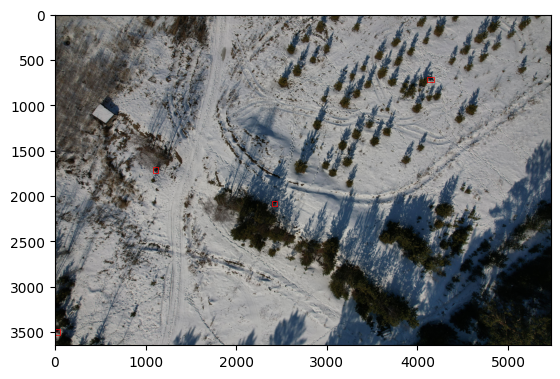

In [91]:
for img_name in images_files:
    if img_name != "data/images/01/1_000482.JPG":
        continue
    img_file = Path(img_name)
    label_file_matched = find_relaxed_match_in_array(map(str, labels_files), img_file.stem)

    if file_have_data(label_file_matched):
        boxes = np.loadtxt(label_file_matched, delimiter=' ')
        if boxes.ndim == 1:
            boxes = boxes.reshape((1, -1))
        img = Image.open(img_file)
        height, width = img.size
        fig, ax = plt.subplots()
        ax.imshow(img)
        print(f"There is {len(boxes)} bodys")
        for box in boxes:
            _, x, y, w, h = box
            print(x, y, w, h)
            x1, y1, x2, y2 = bbox_transformer([x, y, w, h], (height, width),"matplotlib")
            rect = patches.Rectangle((x1,y1), x2, y2, linewidth=0.5, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.show()


# build COCO dataset

Creating header

In [67]:
info = {"description": "Human Rescue dataset", "year": "2024", "version": "0.1",  "url": "https://disk.yandex.ru/d/bN06_6ncEXTLIw/01_train-s1__DataSet_Human_Rescue", "date_created": "24-10-19 23:07"}
license = {"id": 1, "url": "https://creativecommons.org/licenses/by/4.0", "name": "CC BY 4.0"}
categories = {"id": 0, "name": "body"}


Create annotations list and images list

In [101]:
DATA_PATH = Path("./data")
IMG_DIR = DATA_PATH / "images"
LABELS_DIR = DATA_PATH / "labels"

IMG_PART = [i for i in IMG_DIR.iterdir()]
LABELS_PART= [i for i in LABELS_DIR.iterdir()]

total_label_files = 0
id_counter = 0

img_with_labels = []
annotations = []
images = []
for img_part, labels_part in zip(IMG_PART, LABELS_PART):
    images_files = glob.glob(str(img_part)+ "/*")
    labels_files = glob.glob(str(labels_part)+ "/*")
    assert len(images_files) == len(labels_files)
    total_label_files += len(labels_files)
    for label_file in labels_files:
        if not file_have_data(label_file):
            continue
        img_with_labels.append(label_file)
        img_path = get_img_path(label_file)
        if img_path:
            img_entry = get_img_info(img_path, id_counter)
            label_entry = get_label_info(label_file, img_entry)
            id_counter += 1
        else:
            raise FileExistsError(f"No IMG for label {label_file}")
        annotations += label_entry
        images.append(img_entry)
    print(f"'{labels_part}' has", len(img_with_labels), "/", len(labels_files))
print(f"Labeled {len(img_with_labels)} out of {total_label_files}")


'data/labels/01' has 257 / 341
Labeled 257 out of 341


In [102]:
check_id = 171
for img in images:
    if img["id"] == check_id:
        print(img)
for label in annotations:
    if label["image_id"] == check_id:
        print(label)

{'id': 171, 'width': 5472, 'height': 3648, 'file_name': 'data/images/01/1_000482.JPG', 'date_captured': '2024-10-19 19:58:59.767456'}
{'image_id': 171, 'category_id': 0, 'bbox': [4106, 685, 73.513190016, 59.414844672]}
{'image_id': 171, 'category_id': 0, 'bbox': [1077, 1683, 63.442909728000004, 64.449989376]}
{'image_id': 171, 'category_id': 0, 'bbox': [0, 3465, 59.101668432, 67.806594432]}
{'image_id': 171, 'category_id': 0, 'bbox': [2393, 2051, 55.386620928, 62.435833728000006]}


In [99]:
data = {
    "info": info,
    "license": [license],
    "categories": [categories],
    "images": images,
    "annotations": annotations
}
save_json(data, "train.json")

# DETR


In [7]:
import os
import supervision
import transformers
import torchvision
import pytorch_lightning

print(f"{pytorch_lightning.__version__ =}\n{supervision.__version__=}\n{transformers.__version__=}")

pytorch_lightning.__version__ ='2.4.0'
supervision.__version__='0.3.0'
transformers.__version__='4.44.2'


# COCO data loaders

Only one class = ['body']